In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
conn = sqlite3.connect('../DataBootcamp Project 1/188-million-us-wildfires/FPA_FOD_20170508.sqlite')

In [29]:
df = pd.read_sql("""
                       
                        SELECT *
                        from fires 
                        where state='CA'
                        
                       """, con=conn)

In [30]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [275]:
## Pull in Discovery Date & Contained Date as Dates from SQL DB
Disc_Date_Conv = pd.read_sql("""
                                SELECT date(DISCOVERY_DATE) as date
                                FROM fires
                                Where State = 'CA'

                                """,con = conn)
Disc_Date_Conv.date = pd.to_datetime(Disc_Date_Conv.date)
Cont_Date_Conv = pd.read_sql("""
                                SELECT date(CONT_DATE) as date
                                FROM fires
                                Where State = 'CA'

                                """,con = conn)
Cont_Date_Conv.date = pd.to_datetime(Cont_Date_Conv.date)

In [292]:
## Add formatted Discovery Date & Contained Date to new columns 
df['Discovery_Date_st'] = Disc_Date_Conv
df['Contained_Date_st'] = Cont_Date_Conv

### Calculate Burn Duration (Discovery Dt - Contained Dt)
df['Burn_Duration']= df['Contained_Date_st'] - df['Discovery_Date_st']

### Convert Burn Duration to number and populate in new column called 'Burn Days' 
df['Burn_Days']=df.Burn_Duration.dt.days

### Add Column for Acres Burned per Day ()
df['Fire_Speed-Acres_Burned_per_Day'] = df.FIRE_SIZE/df.Burn_Days 

df.head(1)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIPS_CODE,FIPS_NAME,Shape,Discovery_Date_std,Contained_Date_std,Burn_Duration,Burn_Days,Discovery_Date_st,Contained_Date_st,Fire_Speed-Acres_Burned_per_Day
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02,0 days,0.0,2005-02-02,2005-02-02,inf


### Create Summary Dataframe with only Pertinent Columns

In [312]:
## Pare down table to columns being used
df_summary = df[[
       'FIRE_NAME','SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR',
       'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_DESCR', 'STATE','FIPS_NAME', 'Discovery_Date_st',
       'Contained_Date_st', 'Burn_Duration','Burn_Days','Fire_Speed-Acres_Burned_per_Day']]
df_summary.head()

# df_summary.loc[df_summary.Burn_Duration == df_summary.Burn_Duration.max()]


,FIRE_NAME,SOURCE_REPORTING_UNIT_NAME,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,Discovery_Date_st,Contained_Date_st,Burn_Duration,Burn_Days,Fire_Speed-Acres_Burned_per_Day
59660,FARRIS,Grasslands Wildlife Management Area,1999,Debris Burning,0.5,B,37.309539,-120.860325,OTHER FEDERAL,CA,None,1999-07-19,2009-07-19,3653 days,3653.0,0.000137
59744,LUDINGTON,Grasslands Wildlife Management Area,1999,Debris Burning,0.5,B,37.078344,-120.934950,MISSING/NOT SPECIFIED,CA,None,1999-06-16,2009-06-16,3653 days,3653.0,0.000137
59810,TORRES,Pixley National Wildlife Refuge,1999,Miscellaneous,0.1,A,35.899314,-119.276954,OTHER FEDERAL,CA,None,1999-08-11,2009-08-11,3653 days,3653.0,0.000027
59823,COCHARAN,Pixley National Wildlife Refuge,1999,Miscellaneous,0.5,B,35.899284,-119.294765,OTHER FEDERAL,CA,None,1999-07-11,2009-07-11,3653 days,3653.0,0.000137


### Create Summary Tables using Groupby

In [336]:
#Summary by Year
df_summary_year = df_summary.groupby(['FIRE_YEAR']) 
df_summary_max = df_summary.groupby(['FIRE_YEAR']).max()
df_summary_min = df_summary.groupby(['FIRE_YEAR']).min()
df_summary_avg = df_summary.groupby(['FIRE_YEAR']).mean()

#Summary by Year by Cause
df_summary_YearxCause = df_summary.groupby(['FIRE_YEAR','STAT_CAUSE_DESCR'])
df_summary_YearxCause_max = df_summary_YearxCause.max() 
df_summary_YearxCause_avg = df_summary_YearxCause.mean()
# df_summary_YearxCause_max[['FIRE_SIZE','Burn_Days','Fire_Speed-Acres_Burned_per_Day']].head()

#Summary by Year by County (FIPS Name)
df_summary_YearxCounty = df_summary.groupby(['FIRE_YEAR','FIPS_NAME'])
df_summary_YearxCounty_max = df_summary_YearxCounty.max()
df_summary_YearxCounty_avg = df_summary_YearxCounty.mean()
df_summary_YearxCounty_avg[['FIRE_SIZE','Burn_Days','Fire_Speed-Acres_Burned_per_Day']]

df_summary_YearxCounty_max

Burn_Days Burn_Duration Contained_Date_st  \
FIRE_YEAR FIPS_NAME                                                    
1997      El Dorado              0.0        0 days        1997-10-28   
          Lassen                 0.0        0 days        1997-06-11   
          Modoc                  3.0        3 days        1997-10-05   
          Placer                 0.0        0 days        1997-10-21   
          Shasta                 0.0        0 days        1997-09-03   
          Siskiyou               0.0        0 days        1997-07-28   
          Tuolumne               0.0        0 days        1997-11-24   
1998      Alameda                0.0        0 days        1998-07-19   
          Amador                 0.0        0 days        1998-11-09   
          Butte                  0.0        0 days        1998-11-03   
          Calaveras              0.0        0 days        1998-12-31   
          Colusa                 0.0        0 days        1998-10-26   
          El Dorado              1.0        1 days        1998-11-17   
          Fresno                 2.0        2 days        1998-11-27   
          Glenn                  0.0        0 days        1998-10-23   
          Humboldt               1.0        1 days        1998-11-08   
          Inyo                   2.0        2 days        1999-01-02   
          Kern                   0.0        0 days        1998-12-13   
          Lake                   1.0        1 days        1998-10-18   
          Lassen                 1.0        1 days        1998-10-20   
          Madera                 3.0        3 days        1998-10-18   
          Mariposa               1.0        1 days        1998-10-20   
          Mendocino              1.0        1 days        1998-10-30   
          Modoc                  0.0        0 days        1998-10-23   
          Monterey               0.0        0 days        1998-10-25   
          Napa                   0.0        0 days        1998-09-08   
          Nevada                 1.0        1 days        1998-12-25   
          Placer                 1.0        1 days        1998-10-19   
          Plumas                 0.0        0 days        1998-09-05   
          Riverside              1.0        1 days        1998-12-29   
...                              ...           ...               ...   
2015      Nevada                 2.0        2 days        2015-12-31   
          Orange                 1.0        1 days        2015-12-28   
          Placer                 4.0        4 days        2015-12-17   
          Plumas                16.0       16 days        2015-12-07   
          Riverside              7.0        7 days        2015-12-30   
          Sacramento             1.0        1 days        2015-10-03   
          San Benito             4.0        4 days        2015-10-16   
          San Bernardino        28.0       28 days        2015-12-26   
          San Diego              8.0        8 days        2015-12-08   
          San Francisco          NaN           NaT               NaT   
          San Joaquin            0.0        0 days        2015-10-29   
          San Luis Obispo       12.0       12 days        2015-12-29   
          San Mateo              0.0        0 days        2015-11-17   
          Santa Barbara          6.0        6 days        2015-11-29   
          Santa Clara            1.0        1 days        2015-11-24   
          Santa Cruz             1.0        1 days        2015-12-01   
          Shasta                10.0       10 days        2015-12-01   
          Sierra                 2.0        2 days        2015-10-08   
          Siskiyou              15.0       15 days        2015-11-26   
          Solano                 0.0        0 days        2015-11-13   
          Sonoma                14.0       14 days        2015-11-12   
          Stanislaus             1.0        1 days        2015-10-29   
          Sutter                 NaN           NaT               Na

#### Pull Largest Fire for Each Year w/ All Info - WIP 

In [318]:
## Pull Largest Fire for Each Year
Annual_Lgst_Fire = df_summary.groupby(['FIRE_YEAR']).agg({'FIRE_SIZE':'max'})
Annual_Lgst_Fire=Annual_Lgst_Fire.reset_index()
test=[]
test_df = pd.DataFrame([])
## Create Dataframe of all info on largest fire per year
for x in Annual_Lgst_Fire.FIRE_SIZE:
#     print(x)
    test.append(dict(df_summary[df_summary.FIRE_SIZE==x]))

test_df = pd.DataFrame(data=test)
test_df.head(1)

,Burn_Days,Burn_Duration,Contained_Date_st,Discovery_Date_st,FIPS_NAME,FIRE_NAME,FIRE_SIZE,FIRE_SIZE_CLASS,FIRE_YEAR,Fire_Speed-Acres_Burned_per_Day,LATITUDE,LONGITUDE,OWNER_DESCR,SOURCE_REPORTING_UNIT_NAME,STATE,STAT_CAUSE_DESCR
0,"10163 10.0 Name: Burn_Days, dtype: float64","10163 10 days Name: Burn_Duration, dtype: ti...","10163 1992-08-30 Name: Contained_Date_st, dt...","10163 1992-08-20 Name: Discovery_Date_st, dt...","10163 None Name: FIPS_NAME, dtype: object","10163 FOUNTAIN Name: FIRE_NAME, dtype: object","10163 64000.0 Name: FIRE_SIZE, dtype: float64","10163 G Name: FIRE_SIZE_CLASS, dtype: object","10163 1992 Name: FIRE_YEAR, dtype: int64",10163 6400.0 Name: Fire_Speed-Acres_Burned_...,"10163 40.761667 Name: LATITUDE, dtype: float64","10163 -121.98 Name: LONGITUDE, dtype: float64",10163 MISSING/NOT SPECIFIED Name: OWNER_DES...,10163 Shasta-Trinity National Forest Name: ...,"10163 CA Name: STATE, dtype: object","10163 Arson Name: STAT_CAUSE_DESCR, dtype: ..."


In [195]:
#Max Fire Size in Total Fire Population
df_summary.loc[df_summary['FIRE_SIZE']==df_summary['FIRE_SIZE'].max()]

,FIRE_NAME,SOURCE_REPORTING_UNIT_NAME,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,Discovery_Date_std,Contained_Date_std,Burn_Duration,Burn_Days
156166,RUSH,NorCal Region,2012,Lightning,315578.8,G,40.6153,-120.1153,BLM,CA,Lassen,2012-08-12,2012-10-22,71 days,71.0


In [324]:
#Max Fire Duration in Total Fire Population
df_summary.loc[df_summary['Burn_Days']==df_summary['Burn_Days'].max()]

,FIRE_NAME,SOURCE_REPORTING_UNIT_NAME,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,Discovery_Date_st,Contained_Date_st,Burn_Duration,Burn_Days,Fire_Speed-Acres_Burned_per_Day
59660,FARRIS,Grasslands Wildlife Management Area,1999,Debris Burning,0.5,B,37.309539,-120.860325,OTHER FEDERAL,CA,None,1999-07-19,2009-07-19,3653 days,3653.0,0.000137
59744,LUDINGTON,Grasslands Wildlife Management Area,1999,Debris Burning,0.5,B,37.078344,-120.934950,MISSING/NOT SPECIFIED,CA,None,1999-06-16,2009-06-16,3653 days,3653.0,0.000137
59810,TORRES,Pixley National Wildlife Refuge,1999,Miscellaneous,0.1,A,35.899314,-119.276954,OTHER FEDERAL,CA,None,1999-08-11,2009-08-11,3653 days,3653.0,0.000027
59823,COCHARAN,Pixley National Wildlife Refuge,1999,Miscellaneous,0.5,B,35.899284,-119.294765,OTHER FEDERAL,CA,None,1999-07-11,2009-07-11,3653 days,3653.0,0.000137


## Chart Data

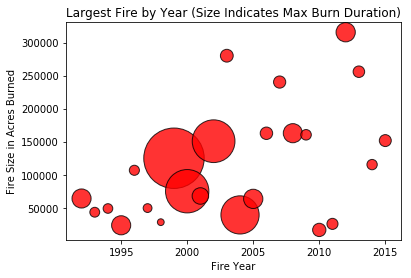

In [325]:
plt.scatter(df_summary_max.index,df_summary_max.FIRE_SIZE,c='red',s=df_summary_max.Burn_Days, alpha = .8,edgecolor='black')
plt.ylabel('Fire Size in Acres Burned')
plt.xlabel('Fire Year')
plt.title('Largest Fire by Year (Size Indicates Max Burn Duration)')
plt.show()

In [330]:
# df_summary_max.head()

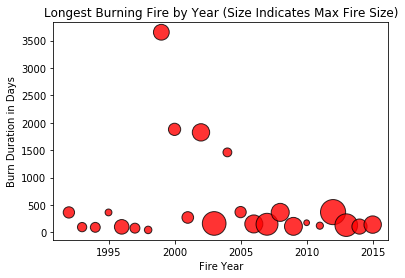

In [326]:
plt.scatter(df_summary_max.index,df_summary_max.Burn_Days,s=df_summary_max.FIRE_SIZE*.002,c='red', alpha = .8,edgecolor='black')
plt.ylabel('Burn Duration in Days')
plt.xlabel('Fire Year')
plt.title('Longest Burning Fire by Year (Size Indicates Max Fire Size)')
plt.show()

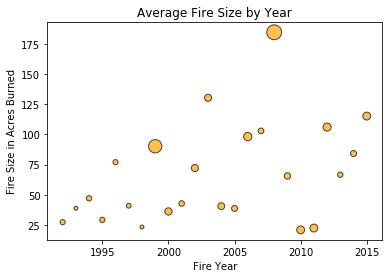

In [327]:
plt.scatter(df_summary_avg.index,df_summary_avg.FIRE_SIZE,s=df_summary_avg.Burn_Days*50, c='orange', alpha=.7, edgecolor='black')
plt.ylabel('Fire Size in Acres Burned')
plt.xlabel('Fire Year')
plt.title('Average Fire Size by Year')
plt.show()

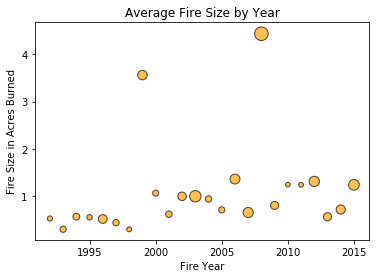

In [328]:
plt.scatter(df_summary_avg.index,df_summary_avg.Burn_Days,s=df_summary_avg.FIRE_SIZE, c='orange', alpha=.7, edgecolor='black')
plt.ylabel('Fire Size in Acres Burned')
plt.xlabel('Fire Year')
plt.title('Average Fire Size by Year')
plt.show()

### Seaborn Charts

In [331]:
df_summary_YearxCause_avg.head(1)

,,FIRE_SIZE,LATITUDE,LONGITUDE,Burn_Days,Fire_Speed-Acres_Burned_per_Day
FIRE_YEAR,STAT_CAUSE_DESCR,,,,,
1992,Arson,78.805281,37.297407,-120.290973,0.576408,inf


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

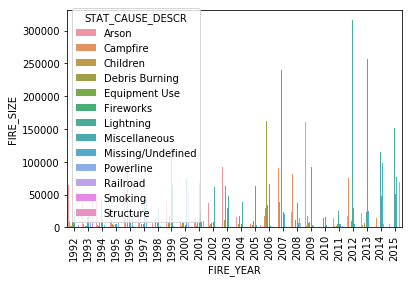

In [341]:
import seaborn as sns
temp = df_summary_YearxCause_max[['FIRE_SIZE']]
#temp.columns = ['Total Acres Burned']
temp = temp.reset_index()

sns.barplot(y='FIRE_SIZE', x='FIRE_YEAR', hue='STAT_CAUSE_DESCR', data=temp)
plt.xticks(rotation=90)

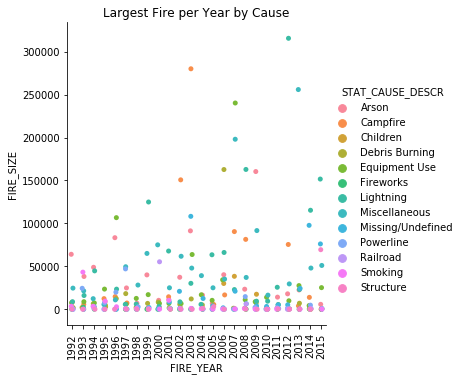

In [355]:
sns.catplot(x='FIRE_YEAR',y='FIRE_SIZE',hue='STAT_CAUSE_DESCR', data=temp)
plt.xticks(rotation=90)
plt.title('Largest Fire per Year by Cause')
plt.show()

Text(0.5,1,'Largest Fire by County')

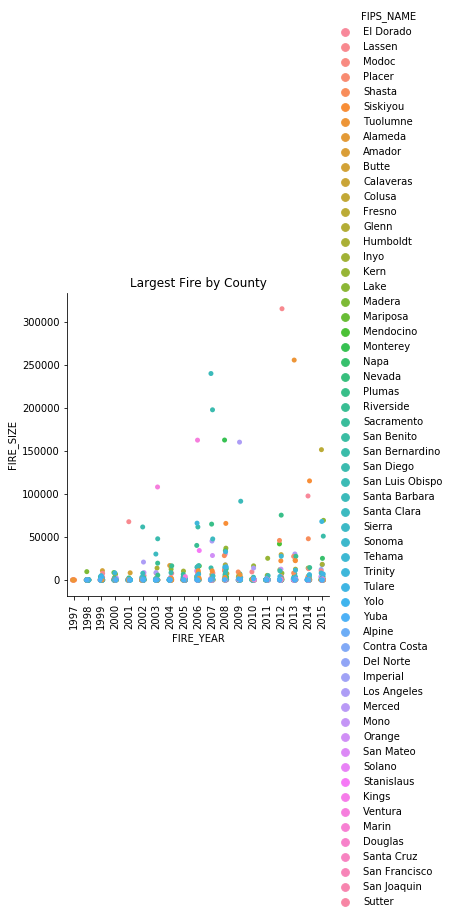

In [347]:
temp2 = df_summary_YearxCounty_max[['FIRE_SIZE']]
temp2 = temp2.reset_index()

sns.catplot(y='FIRE_SIZE', x='FIRE_YEAR', hue='FIPS_NAME', data=temp2)
plt.xticks(rotation=90)
plt.title('Largest Fire by County')